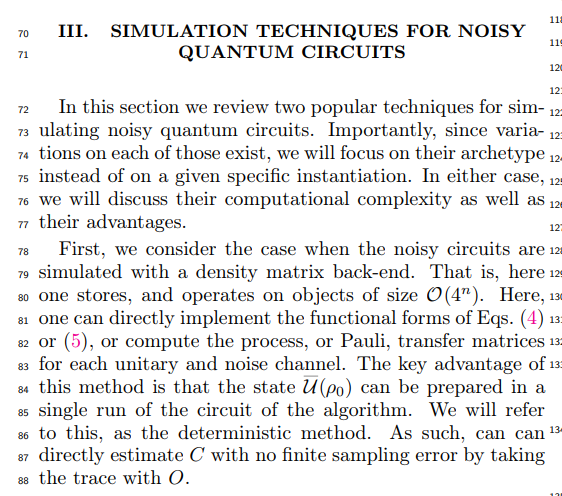

# 1 Deterministic Method

## 1.a) Without finite sampling

In order to achieve this, first we are going to define the quantum channels to study this

In [1]:
import pennylane as qml
from pennylane import numpy as pnp

#Phaseflip Channel, the standard fully polarized 
#channel is obtained for values of p = 0.5
def ZPhaseFlip(sigma, p= 0.5):
    sz = qml.Z(1).matrix()
    return (1 - p) * sigma + p * sz @ sigma @ sz

#Bitflip Channel
def XPhaseFlip(sigma, p= 0.5):
    sx = qml.X(1).matrix()
    return (1 - p) * sigma + p * sx @ sigma @ sx

#Depolarizing Channel:
def Depolarizing(sigma, p= 0.5):
    id = qml.Identity(1).matrix()
    
    return (1 - p) * sigma + p * id / 2

#Decay Prob Channel:
def DecayProb(sigma, p= 0.5):

    K0 = pnp.array([[0, pnp.sqrt(p)], # <√p |0><1|
                    [0, 0]])
    
    K1 = pnp.array([[1, 0], # |0><0|
                    [0, pnp.sqrt(1-p)]]) #√(1-p) |1><1|

    snew = pnp.sum( [ Kmu @ sigma @ pnp.conj(Kmu.T) for Kmu in [K0, K1] ], axis= 0 ) 

    return snew


In [3]:

"""
def KrausChannel(sigma, prob_dist, Krauss_ops):


    return pnp.sum(  [p * Kmu @ sigma @ Kmu.conjugate().transpose() 
                      for p, Kmu in zip(prob_dist, Krauss_ops) ], axis= 0 ) 



def ZPhaseFlip(sigma, p):
    return KrausChannel(sigma, 
                        prob_dist= [1 - p, p],
                        Krauss_ops= [qml.Identity(1), qml.Z(1).matrix()])

def XPhaseFlip(sigma, p):
    return KrausChannel(sigma, 
                        prob_dist= [1 - p, p],
                        Krauss_ops= [qml.Identity(1), qml.X(1).matrix()])

def Depolarizing(sigma, p):

    s0 = qml.Identity(1)
    sx = qml.X(1).matrix()
    sy = qml.Y(1).matrix()
    sz = qml.Z(1).matrix()
    
    return KrausChannel(sigma, 
                        prob_dist= [1 - 3 * p / 4, p/4,
                                    p/4, p/4 ],
                        Krauss_ops= [s0, sx, sy, sz] )

def DecayChannel(sigma, p):

    K0 = pnp.array([[0, pnp.sqrt(p)], # √p |0><1|
                    [0, 0]])
    
    K1 = pnp.array([[1, 0], # |0><0|
                    [0, pnp.sqrt(1-p)]]) #√(1-p) |1><1|

    return KrausChannel(sigma, 
                        prob_dist= [1, 1],
                        Krauss_ops= [K0, K1] )

"""

'\ndef KrausChannel(sigma, prob_dist, Krauss_ops):\n\n\n    return pnp.sum(  [p * Kmu @ sigma @ Kmu.conjugate().transpose() \n                      for p, Kmu in zip(prob_dist, Krauss_ops) ], axis= 0 ) \n\n\n\ndef ZPhaseFlip(sigma, p):\n    return KrausChannel(sigma, \n                        prob_dist= [1 - p, p],\n                        Krauss_ops= [qml.Identity(1), qml.Z(1).matrix()])\n\ndef XPhaseFlip(sigma, p):\n    return KrausChannel(sigma, \n                        prob_dist= [1 - p, p],\n                        Krauss_ops= [qml.Identity(1), qml.X(1).matrix()])\n\ndef Depolarizing(sigma, p):\n\n    s0 = qml.Identity(1)\n    sx = qml.X(1).matrix()\n    sy = qml.Y(1).matrix()\n    sz = qml.Z(1).matrix()\n    \n    return KrausChannel(sigma, \n                        prob_dist= [1 - 3 * p / 4, p/4,\n                                    p/4, p/4 ],\n                        Krauss_ops= [s0, sx, sy, sz] )\n\ndef DecayChannel(sigma, p):\n\n    K0 = pnp.array([[0, pnp.sqrt(p)], # √p |0

Then, one can use the deterministic method to obtain a
90 finite shots approximate of C. Here, we start from U(ρ0)
91 and make N measurements in the eigenbasis of O, to obtain
92 the finite sample approximate Ce of C.

## We will try the next state:

$$
\ket{\psi} = 0.71803 \ket{0} + (0.357943 - 0.596917 i) \ket{1}
$$

In [2]:
#random state choosen by José grande José
psi = pnp.array([0.71803, 0.357943 - 0.596917j])
psi = psi / pnp.linalg.norm(psi) #sanity check to confirm that is normalized

# we will now generate the density matrix associated to 
# the state:
rho = pnp.outer(psi, pnp.conj(psi))

#Now, we defined our operator as the Z operator
Obs = pnp.array([[1, 0],
                 [0, -1]]) 

#now we will generate the $\bar{U}(\rho)$ state:
noisy_rho = ZPhaseFlip(rho)

#And compute the Noisy Expectation Value:


det_C_not_sampled = pnp.trace(noisy_rho @ Obs)
print(f'Noisy Exp Value: {det_C_not_sampled:.8f}')

#No finite Sampling error

Noisy Exp Value: 0.03113398+0.00000000j


In [3]:
#Sanity check
#we will show that, indeed this is an unbiased estimator:
#if we utilized the expression of the Line 156 of the latex 

eigval, eigvec = pnp.linalg.eig(Obs)

proj = [ pnp.outer(psi, pnp.conj(psi)) for psi in eigvec ]

print(proj)

Es = pnp.sum([Li * pnp.trace( noisy_rho @ ProjI )
             for Li, ProjI in zip(eigval, proj)])

print(Es)

print(det_C_not_sampled-Es)


[tensor([[1., 0.],
        [0., 0.]], requires_grad=True), tensor([[0., 0.],
        [0., 1.]], requires_grad=True)]
(0.031133979250102473+7.025156486097808e-18j)
0j


## 1.b) Deterministic method with finite sampling:

for the deterministic method with finite sampling, we are going to perform $N$ measurements in
the eigenbasis of the $\mathcal{O}$. Specifically, for the case of $\mathcal{O} = Z$, The eignestate is the computational basis and:

$$
\langle Z \rangle = |c0|^2  \bra{0} Z \ket{0} + |c1|^2 \bra{1} Z \ket{1}
$$
Where $\ket{\psi} = c0 \ket{0} + c1 \ket{1}$ is the def of expected value

whit this, the sampling data $s = \{ \lambda_{m(s)} \}_{s = 1}^{N} =  \{ \lambda_1, \lambda_2, \cdot, \lambda_N \}$, we can make stadistics with this data set:




In [4]:
import numpy as np
import pennylane.numpy as pnp
from joblib import Parallel, delayed


def finite_sample_datasetv2(N_shots, density_matrix, Observable):
    # Obtenemos el espectro del observable
    eigval, eigvec = pnp.linalg.eig(Observable)

    # Convertimos `eigvec` en una lista de autovectores columna
    # para generar los projectores \Pi_i = | L_i ><| L_i
    projective_list = [eigvec[:, i:i+1] @ pnp.conj(eigvec[:, i:i+1].T) for i in range(len(eigval))]
    
    # Lista de probabilidades de obtener el autovalor correspondiente
    #born rule: pi = Tr( rho \Pi_i)
    prob_list = [pnp.real(pnp.trace(density_matrix @ Pi_i)) for Pi_i in projective_list]
    
    # Configuraciones para optimización
    num_cores = -1  # Usará todos los núcleos disponibles
    batch_size = 1000  # Tamaño de lotes para cada núcleo

    def sample_batch(size):
        # Seleccionamos un autovalor según las probabilidades
        return pnp.random.choice(eigval, size=size, p=prob_list)

    # Muestreo en paralelo
    dataset = Parallel(n_jobs=num_cores)(delayed(sample_batch)(batch_size) for _ in range(N_shots // batch_size))
    dataset = pnp.concatenate(dataset)
    
    # Generar remanente si N_shots no es divisible por batch_size
    remainder = N_shots % batch_size
    if remainder > 0:
        dataset = pnp.concatenate([dataset, sample_batch(remainder)])
    
    return dataset


In [5]:
N_shots = 10 ** 6


det_finite_data = finite_sample_datasetv2(N_shots, rho, Obs)

mean = pnp.mean(det_finite_data)
std_dev = pnp.std(det_finite_data)
var_dev = pnp.var(det_finite_data)

print(f'Mean: {mean}')
print(f'Standar deviation: {std_dev}')
print(f'Variancie: {var_dev}')




Mean: 0.030888
Standar deviation: 0.9995228518928418
Variancie: 0.9990459314559998


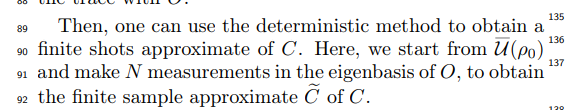

Now Lets compute $ \hat{C}² = \dfrac{1}{N^2} \sum \limits_{s, s' = 1}^N \lambda_{m(s)} \lambda_{m(s')}$

pregunta: ¿hay que ocupar distintos datasets?

R: Si, es el mismo

In [9]:
probTreshold = pnp.absolute(psi[0]) ** 2

Nshots = 10 ** 5

LsampleList = [ 1 if pnp.random.rand() <= probTreshold 
               else -1
               for _ in range(Nshots)]

Csquare = pnp.sum( [ ls * lsprime for ls in LsampleList for lsprime in LsampleList] ) / (Nshots * Nshots)

print(Csquare)

KeyboardInterrupt: 

In [10]:
VarsCdet = (pnp.trace( noisy_rho @ Obs @ Obs ) - pnp.trace(noisy_rho @ Obs) ** 2) / (Nshots * Nshots)

#VarsCDet

print(VarsCdet)

(9.990306753360547e-11-7.462598638631592e-28j)


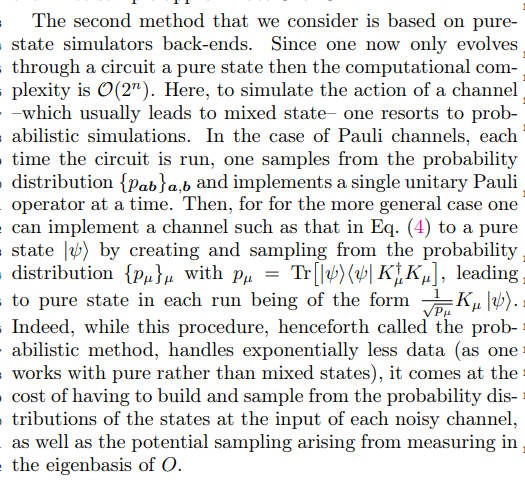

In [ ]:
#num of operators. here we will


# 2nd Part: Probabilistic method

Con lo conversado con José, el como se utiliza de manera probabilistica la simulacion de ruido es que, al entrar un canal cuantico, se elige sobre los set de operadores de kraus de un canal cuantico la probabilidad de que se le aplique este dado la dsitribución de probabilidad:

generemos esto con el codigo:

1) Armar la dist de prob $\{ p_\mu \}_{\mu = 0}^{k}$ y con $p_\mu = \text{Tr}(\ket{\psi}\bra{\psi} K_\mu ) = \bra{\psi} K_\mu \ket{\psi}$

comentario: (significa esto que hayan estados que pasan piola para ciertos canales cuanticos/que estan protegidos de estos??/ respuesta: Si! x ej los autoestados de X son invariantes
ante el X-flip


2) elegir que operador de Krauss se le aplica con la correspondiente distribución de probabilidad

3) El estado final será $ \ket{\psi'}=\frac{1}{\sqrt{p_\mu}} K_\mu \ket{\psi}$

En el caso de hacer probabilistico sin finite sample:

4) Calculamos el valor de expecation del observable como $C = \bra{\psi'} \mathcal{O} \ket{\psi'}$

En el caso de hacer probabilistic con finite sampling:

4) Realizamos $N$ mediciones en la base de autoestados del observable $\mathcal{O}$ (the so called trials(?)) y reconstruimos el valor esperado en base
a la reconstrucción de los eigenvalues


Arising question:

consider the set of kraus op:

$\{ K_0 = I, K_1 = X \}$ and the state $\ket{+} = (\ket{0} + \ket{1})/ \sqrt{2}$

we've got that:

$p_0 = \bra{+} \ket{+} = 1$ and $p_1 = \bra{+} X \ket{+} = \bra{+} \ket{+} = 1$

so the prob dist is {1, 1}. Does this means that both canals have 100% prob of being applied?? how should we handle this??¿

I will asume that it is necesary to renormalize the prob distribution


In [19]:
import numpy as np
import pennylane as qml


def pmu(state_vector, Kmu):
    return  pnp.trace(state_vector @ pnp.conj(state_vector.T) @ pnp.conj(Kmu.T) @ Kmu)

def Prob_Noisy_Channel(state_vector, list_Krauss_ops):

    # Asegurarse de que vector_state sea un vector columna (2,1)
    state_vector = state_vector.reshape(-1, 1)  # Esto convierte el vector a una columna
    
    # Armamos la distribución de probabilidad
    prob_dict = { f'K_{i}' : (Kmu, pmu(state_vector, Kmu))
                 for i, Kmu in enumerate(list_Krauss_ops) }

    
    # Lista de probabilidades
    prob_dist = [value[1] for value in prob_dict.values()]
    
    # Lista de matrices Kraus
    kraus_matrices = [value[0] for value in prob_dict.values()]
    
    # Elegir la tupla con la distribución de probabilidad
    choosen_index = np.random.choice(len(prob_dict), p= prob_dist)
    
    #obviusly this can be optimized...
    p_mu, K_mu = prob_dist[choosen_index], kraus_matrices[choosen_index]
    
    noisy_state_vector = (1 / pnp.sqrt(p_mu)) * K_mu @ state_vector
    return noisy_state_vector


def prob_Z_flip_ch(vector_state, p= 0.5):

    #Op de Kraus asociados al canal Z-flip
    K0 = pnp.sqrt(1 - p) * qml.Identity(1).matrix()
    K1 = pnp.sqrt(p) * qml.Z(1).matrix()

    K_ops = [K0, K1]

    return Prob_Noisy_Channel(vector_state= vector_state,
                              list_Krauss_ops= K_ops)


def prob_X_flip_ch(vector_state, p= 0.5):

    # Op de Kraus asociados al canal X-flip

    K0 = pnp.sqrt(1 - p) * qml.Identity(1).matrix()
    K1 = pnp.sqrt(p) * qml.X(1).matrix()

    K_ops = [K0, K1]

    return Prob_Noisy_Channel(vector_state= vector_state,
                              list_Krauss_ops= K_ops)


def prob_depolarizing_ch(vector_state, p= 0.5):
    
    #calculamos las ctes de los op de Krauss
    c1 = pnp.sqrt(p) / 2
    c2 = pnp.sqrt(1 - 3 * p / 4)

    #definimos los op de Krauss
    K0 = c2 * qml.Identity(1).matrix()
    K1 = c1 * qml.X(1).matrix()
    K2 = c1 * qml.Y(1).matrix()
    K3 = c1 * qml.Z(1).matrix()
    
    K_ops = [K0, K1, K2, K3]

    return Prob_Noisy_Channel(state_vector= vector_state,
                              list_Krauss_ops= K_ops)


def prob_decay_ch(vector_state, p= 0.5):
 
    K0 = pnp.array([[0, pnp.sqrt(p)], # √p |0><1|
                    [0, 0]])
    
    K1 = pnp.array([[1, 0], # |0><0|
                    [0, pnp.sqrt(1-p)]]) #√(1-p) |1><1|
    
    K_ops = [K0, K1]

    return Prob_Noisy_Channel(vector_state= vector_state,
                              list_Krauss_ops= K_ops)


# C estimator for probabilist with no finite sample:


## First Method:

compute $N$ times the noisy statevector $\ket{\psi_{\text{Noisy}}} = \frac{1}{\sqrt{p_\mu}} = K_\mu \ket{\psi}$ and then take the average of all the obtained $\bra{\psi_{\text{Noisy}}} O \ket{\psi_{\text{Noisy}}}$

## Second method:

question: In eq:

$$
\hat{C} = \frac{1}{N} \sum \limits_{t= 1}^{N} \text{Tr} [ K_t \rho_0 K_t^\dagger O  ]
$$

that once the state passes trought the noisy channel changes as $\ket{\psi} \to \frac{1}{ \sqrt{p_\mu}} K_\mu \ket{\psi} $

can I assume that $K_t \rho_0 K_t^\dagger = \frac{1}{p_t} K_t \ket{\psi} \bra{\psi} K_t^\dagger $ ??¿¿?

bcs, if so $\hat{C} = \frac{1}{N} \sum \limits_{t= 1}^{N} \text{Tr}[ \frac{1}{p_t} K_t \ket{\psi} \bra{\psi} K_t^\dagger O ] = \frac{1}{N} \sum \limits_{t=1}^{N} \frac{1}{p_t} \bra{\psi} K_t^{\dagger} O K_t \ket{\psi}$ 



In [7]:

# Probabilistc method with no finite sampling
def prob_nfs_data(N_shots, state_vector, Observable):
    
    #dataset to return
    dataset = pnp.zeros(N_shots)

    # Obtain the spectrum of the observable
    eigval, eigvec = pnp.linalg.eig(Observable)

    #then we transform the statevector to the eigenbasis
    # Of the observables
    eigvec_inv = pnp.linalg.inv(eigvec)

    eigbasis_State_vec = pnp.dot(eigvec_inv, state_vector)
    
    # now we compute the prob vector of obtain each of the eigenvalues 
    prob_eigvector = pnp.real(eigbasis_State_vec * pnp.conj(eigbasis_State_vec))


    for i in range(N_shots):
        sampled_eigvalue = pnp.random.choice(eigval, p= prob_eigvector) 
        dataset[i] = sampled_eigvalue
    
    return dataset


In [ ]:
import pennylane.numpy as pnp
from joblib import Parallel, delayed

# Probabilistic method with no finite sampling
def prob_nfs_data_optimized(N_shots, state_vector, Observable):
    
    # Obtain the spectrum of the observable
    eigval, eigvec = pnp.linalg.eig(Observable)

    # Transform the state vector to the eigenbasis of the observables
    eigvec_inv = pnp.linalg.inv(eigvec)
    eigbasis_State_vec = pnp.dot(eigvec_inv, state_vector)
    
    # Compute the probability vector of obtaining each of the eigenvalues
    prob_eigvector = pnp.array(pnp.real(eigbasis_State_vec * pnp.conj(eigbasis_State_vec)))
    prob_eigvector = prob_eigvector.flatten()

    # Number of available cores for parallelization
    num_cores = -1  # Uses all available cores
    batch_size = 1000  # Size of batches for parallel sampling

    # Function to sample a batch of eigenvalues based on probabilities
    def sample_batch(size):
        return pnp.random.choice(eigval, size=size, p=prob_eigvector)

    # Parallel sampling in batches
    dataset = Parallel(n_jobs=num_cores)(
        delayed(sample_batch)(batch_size) for _ in range(N_shots // batch_size)
    )
    
    # Concatenate all the batches into one dataset
    dataset = pnp.concatenate(dataset)

    # Handle remainder if N_shots is not a multiple of batch_size
    remainder = N_shots % batch_size
    if remainder > 0:
        dataset = pnp.concatenate([dataset, sample_batch(remainder)])

    return dataset



# aqui lo obtendremos será el data set de medir en la base de autoestados de
# del operador O

In [ ]:
eig, eigvec = pnp.linalg.eig(qml.X(1).matrix())

print(eig[0], eigvec[0])



1.0 [ 0.70710678 -0.70710678]


In [ ]:
import concurrent.futures as cf


# No pescar esto de acá

def C_prob_nfs(state_vector, Observable, N_shots ,channel= 'depolarizing'):
    
    channel_dict = {'z flip' : prob_Z_flip_ch,
                    'x flip' : prob_X_flip_ch,
                    'depolarizing' : prob_depolarizing_ch,
                    'decay' : prob_decay_ch}
    
    channel = channel_dict[channel]
    data_traced = pnp.zeros(N_shots)

    for j in range(N_shots):
        noisy_sv = channel(state_vector)
        term = pnp.trace(noisy_sv @ pnp.conj(noisy_sv.T) @ Observable)
        data_traced[j] = term

    
    return pnp.mean(data_traced)


Cprob = C_prob_nfs(psi, Obs, 1_000_000)



/tmp/ipykernel_5680/684174983.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  choosen_index = np.random.choice(len(prob_dict), p=prob_dist)
/tmp/ipykernel_5680/1197738322.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  data_traced[j] = term


KeyboardInterrupt: 

In [ ]:
import concurrent.futures as cf

# Define compute_trace como una función global
def compute_trace(args):
    state_vector, Observable, channel_func = args
    noisy_sv = channel_func(state_vector)
    return pnp.trace(noisy_sv @ pnp.conj(noisy_sv.T) @ Observable)

def C_prob_nfs(state_vector, Observable, N_shots, channel='depolarizing'):
    # Diccionario de funciones de canal
    channel_dict = {
        'z flip': prob_Z_flip_ch,
        'x flip': prob_X_flip_ch,
        'depolarizing': prob_depolarizing_ch,
        'decay': prob_decay_ch
    }
    
    channel_func = channel_dict[channel]

    # Prepara los argumentos como una lista de tuplas
    args = [(state_vector, Observable, channel_func) for _ in range(N_shots)]

    # Ejecuta en paralelo con ProcessPoolExecutor
    with cf.ProcessPoolExecutor() as executor:
        # Mapea la función compute_trace en paralelo
        data_traced = list(executor.map(compute_trace, args))

    # Retorna el promedio
    return pnp.mean(data_traced)

# Ejemplo de uso
Cprob = C_prob_nfs(psi, Obs, 1_000_000)


/tmp/ipykernel_5680/684174983.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  choosen_index = np.random.choice(len(prob_dict), p=prob_dist)
/tmp/ipykernel_5680/684174983.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  choosen_index = np.random.choice(len(prob_dict), p=prob_dist)
/tmp/ipykernel_5680/684174983.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  choosen_index = np.random.choice(len(prob_dict), p=prob_dist)
/tmp/ipykernel_5680/684174983.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  choosen_index = np.random.choice(len(prob_dict), p=prob_dist)
/tmp/ipykernel_5680/684174983.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  choosen_index = np.random.choice(len(prob_dict), p=prob_dist)
/tmp/ipykernel_5680/684174983.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  choose

In [ ]:
#random state choosen by José grande José
psi = pnp.array([0.71803, 0.357943 - 0.596917j])
psi = psi / pnp.linalg.norm(psi) #sanity check to confirm that is normalized

noisy_psi = prob_depolarizing_ch(vector_state= psi, p= 0.5)




{'K_0': (array([[0.70710678, 0.        ],
       [0.        , 0.70710678]]), 0.5), 'K_1': (array([[0.        , 0.70710678],
       [0.70710678, 0.        ]]), 0.5)}
[0.5, 0.5]


array([[0.70710678],
       [0.70710678]])

## Probabilistic without finite sampling:


In [14]:
final_state = pnp.array([1, 0])

C_exp_value_prob_finite = pnp.trace(final_state @ pnp.conj(final_state.T) @ Obs)





ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

## Probabilistic with finite sampling:


In [ ]:
N_trials = 10 ** 5

import numpy as np
import pennylane.numpy as pnp
from joblib import Parallel, delayed



def prob_fs_dataset(N_shots, state_vector, Observable, K_ops):

    state_vector = state_vector.reshape(-1, 1)  # Esto convierte el vector a una columna
    
    # Armamos la distribución de probabilidad
    prob_dict = { f'K_{i}' : (Kmu, pmu(state_vector, Kmu))
                 for i, Kmu in enumerate(K_ops) }


    # Lista de probabilidades
    prob_dist = pnp.real( pnp.array( [value[1] for value in prob_dict.values()]))
    
    # Lista de matrices Kraus
    kraus_matrices = [value[0] for value in prob_dict.values()]
    

    eigval, eigvec = pnp.linalg.eig(Observable)
    #projective_list = [eigvec[:, i:i+1] @ pnp.conj(eigvec[:, i:i+1].T) for i in range(len(eigval))]

    #prob_eigval_dict = { f'K_{i}' : [] }
    
    dataset = pnp.zeros(N_shots)
    


    for j in range(N_shots):
    # Elegir la tupla con la distribución de probabilidad
        choosen_index = np.random.choice(len(prob_dict), p= prob_dist)

        #K_ops_counts[f'K_{choosen_index}'] += 1

        p_mu, K_mu = prob_dist[choosen_index], kraus_matrices[choosen_index]
        
        noisy_statevec = (1 / pnp.sqrt(p_mu)) * K_mu @ state_vector
        
        eigvec_inv = pnp.linalg.inv(eigvec)
        eigbasis_State_vec = pnp.dot(eigvec_inv, noisy_statevec)
    
        # Compute the probability vector of obtaining each of the eigenvalues
        prob_eigvector = pnp.array(pnp.real(eigbasis_State_vec * pnp.conj(eigbasis_State_vec)))
        prob_eigvector = prob_eigvector.flatten()


        chossen_lambdai = pnp.random.choice( eigval, p= prob_eigvector )

        dataset[j] = chossen_lambdai
    
    return dataset



In [42]:
from joblib import Parallel, delayed
import numpy as np
import pennylane.numpy as pnp

def prob_fs_iteration(state_vector, prob_dist, kraus_matrices, eigval, eigvec):
    # Elegir la tupla con la distribución de probabilidad
    choosen_index = np.random.choice(len(prob_dist), p=prob_dist)

    p_mu, K_mu = prob_dist[choosen_index], kraus_matrices[choosen_index]

    noisy_statevec = (1 / pnp.sqrt(p_mu)) * K_mu @ state_vector

    eigvec_inv = pnp.linalg.inv(eigvec)
    eigbasis_State_vec = pnp.dot(eigvec_inv, noisy_statevec)

    # Compute the probability vector of obtaining each of the eigenvalues
    prob_eigvector = pnp.array(pnp.real(eigbasis_State_vec * pnp.conj(eigbasis_State_vec))).flatten()

    # Elegir un eigenvalor basado en la distribución de probabilidad
    chosen_lambdai = pnp.random.choice(eigval, p=prob_eigvector)

    return chosen_lambdai


def prob_fs_dataset(N_shots, state_vector, Observable, K_ops):
    # Crear el vector columna
    state_vector = state_vector.reshape(-1, 1)

    # Armamos la distribución de probabilidad
    prob_dict = {f'K_{i}': (Kmu, pmu(state_vector, Kmu)) for i, Kmu in enumerate(K_ops)}

    # Lista de probabilidades
    prob_dist = pnp.real(pnp.array([value[1] for value in prob_dict.values()]))

    # Lista de matrices Kraus
    kraus_matrices = [value[0] for value in prob_dict.values()]

    # Descomposición del observable
    eigval, eigvec = pnp.linalg.eig(Observable)

    # Usamos joblib para paralelizar
    dataset = Parallel(n_jobs=-1)(
        delayed(prob_fs_iteration)(state_vector, prob_dist, kraus_matrices, eigval, eigvec)
        for _ in range(N_shots)
    )

    return pnp.array(dataset)


In [36]:
def prob_Zflip_fs_ds(N_shots, state_vector, Observable, p= 0.5):
    
    #Op de Kraus asociados al canal Z-flip
    K0 = pnp.sqrt(1 - p) * qml.Identity(1).matrix()
    K1 = pnp.sqrt(p) * qml.Z(1).matrix()

    K_ops = [K0, K1]

    return prob_fs_dataset(N_shots, state_vector, Observable, K_ops= K_ops)


def prob_X_flip_fs_ds(N_shots, state_vector, Observable, p= 0.5):

    # Op de Kraus asociados al canal X-flip
    K0 = pnp.sqrt(1 - p) * qml.Identity(1).matrix()
    K1 = pnp.sqrt(p) * qml.X(1).matrix()

    K_ops = [K0, K1]

    return prob_fs_dataset(N_shots, state_vector, Observable, K_ops= K_ops)



def prob_depolarizing_fs_ds(N_shots, state_vector, Observable, p= 0.5):
    
    #calculamos las ctes de los op de Krauss
    c1 = pnp.sqrt(p) / 2
    c2 = pnp.sqrt(1 - 3 * p / 4)

    #definimos los op de Krauss
    K0 = c2 * qml.Identity(1).matrix()
    K1 = c1 * qml.X(1).matrix()
    K2 = c1 * qml.Y(1).matrix()
    K3 = c1 * qml.Z(1).matrix()
    
    K_ops = [K0, K1, K2, K3]

    return prob_fs_dataset(N_shots, state_vector, Observable, K_ops= K_ops)



def prob_decay_fs_ds(N_shots, state_vector, Observable, p= 0.5):
 
    K0 = pnp.array([[0, pnp.sqrt(p)], # √p |0><1|
                    [0, 0]])
    
    K1 = pnp.array([[1, 0], # |0><0|
                    [0, pnp.sqrt(1-p)]]) #√(1-p) |1><1|
    
    K_ops = [K0, K1]

    return prob_fs_dataset(N_shots, state_vector, Observable, K_ops= K_ops)



# Let's Utilize what we have done:

In [43]:

#random state choosen by José grande José
psi = pnp.array([0.71803, 0.357943 - 0.596917j])
psi = psi / pnp.linalg.norm(psi) #sanity check to confirm that is normalized

# we will now generate the density matrix associated to 
# the state:
rho = pnp.outer(psi, pnp.conj(psi))

#Now, we defined our operator as the Z operator
Obs = pnp.array([[1, 0],
                 [0, -1]]) 

#now we will generate the $\bar{U}(\rho)$ state:
noisy_rho = ZPhaseFlip(rho)

#And compute the Noisy Expectation Value:
det_C_nfs = pnp.trace(noisy_rho @ Obs)

#Now we will compute the deterministic method with finite sample:
N_shots = 10 ** 6

dataset_fs_det = finite_sample_datasetv2(N_shots= N_shots,
                                         density_matrix= rho,
                                         Observable= Obs)

det_C_fs, std_dev_det_fs, var_det_fs = pnp.mean(dataset_fs_det), pnp.std(dataset_fs_det), pnp.var(dataset_fs_det)

#Now we will compute the probabilistic method:

#noisy psi

noisy_psi = prob_depolarizing_ch(psi)

dataset_nfs_prob = prob_nfs_data_optimized(N_shots= N_shots,
                                           state_vector= noisy_psi,
                                           Observable= Obs)

prob_C_nfs, std_dev_prob_nfs, var_prob_nfs = pnp.mean(dataset_nfs_prob), pnp.std(dataset_nfs_prob), pnp.var(dataset_nfs_prob)


dataset_fs_prob = prob_depolarizing_fs_ds(N_shots= N_shots,
                                          state_vector= psi,
                                          Observable= Obs)

prob_C_fs, std_dev_prob_fs, var_prob_fs = pnp.mean(dataset_fs_prob), pnp.std(dataset_fs_prob), pnp.var(dataset_fs_prob)




/tmp/ipykernel_6098/1651826571.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  choosen_index = np.random.choice(len(prob_dict), p= prob_dist)


[0.48443301 0.51556699]


In [45]:
print(f'Noisy Exp Value Determinista NFS: {det_C_not_sampled:.10f}')
print(f'Noisy Exp Value Determinista FS: {det_C_fs:.10f}')
print(f'Noisy Exp Value Prob NFS: {prob_C_nfs:.10f}')
print(f'Noisy Exp Value Prob FS: {prob_C_fs:.10f}')


Noisy Exp Value Determinista NFS: 0.0311339793+0.0000000000j
Noisy Exp Value Determinista FS: 0.0315680000
Noisy Exp Value Prob NFS: -0.0328960000
Noisy Exp Value Prob FS: 0.0155780000


In [3]:
from pennylane import numpy as pnp

#random state choosen by José grande José
psi = pnp.array([0.71803, 0.357943 - 0.596917j])

print(pnp.linalg.norm(psi) )

psi = psi / pnp.linalg.norm(psi) #sanity check to confirm that is normalized

print(pnp.linalg.norm(psi) )


1.000000088518996
1.0000000000000002


In [25]:

N_shots= 100_000
dataset_fs_prob = prob_depolarizing_fs_ds(N_shots= N_shots,
                                          state_vector= psi,
                                          Observable= Obs,
                                          p= 1)

mean = pnp.mean(dataset_fs_prob)
std = pnp.std(dataset_fs_prob)
var = pnp.var(dataset_fs_prob)

print(mean)
print(std)
print(var)

/tmp/ipykernel_6831/1672887906.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  choosen_index = np.random.choice(len(prob_dict), p= prob_dist)


0.00548
0.9999849846872703
0.9999699696000002
